In [1]:
import cv2
import csv
import string
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_path = '/content/drive/MyDrive/archive.zip'
with zipfile.ZipFile(zip_path) as f:
  f.extractall()

In [4]:
def load_az_dataset(data_path):
  with open(data_path) as f:
    csv_reader = csv.reader(f, delimiter=',')
    labels = []
    images = []
    
    for row in csv_reader:
      label = row[0]
      image = np.array([int(x) for x in row[1:]], dtype="uint8")
      image = image.reshape((28, 28))

      labels.append(label)
      images.append(image)
    labels = np.array(labels, dtype='int')
    images = np.array(images, dtype='float32')
    return (images, labels)

In [5]:
def load_digits_dataset():
  ((train_data, train_labels), (test_data, test_labels)) = mnist.load_data()
  data = np.vstack([train_data, test_data])
  labels = np.hstack([train_labels, test_labels])
  return (data, labels)

In [6]:
data_path = "/content/A_Z Handwritten Data.csv"
(az_data, az_labels) = load_az_dataset(data_path)
(digits_data, digits_labels) = load_digits_dataset()

11490434/11490434 [==============================] - 0s 0us/step


In [7]:
az_labels += 10
data = np.vstack([az_data, digits_data])
labels = np.hstack([az_labels, digits_labels])

In [8]:
print(f"Data: {len(data)}, type: {data.dtype}")
print(f"Label: {len(labels)}, type: {labels.dtype}")

Data: 442451, type: float32
Label: 442451, type: int64


In [9]:
labels_name = list(string.digits)+list(string.ascii_lowercase)
print(labels_name)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [10]:
data_ = {"label":labels}
df = pd.DataFrame(data_)

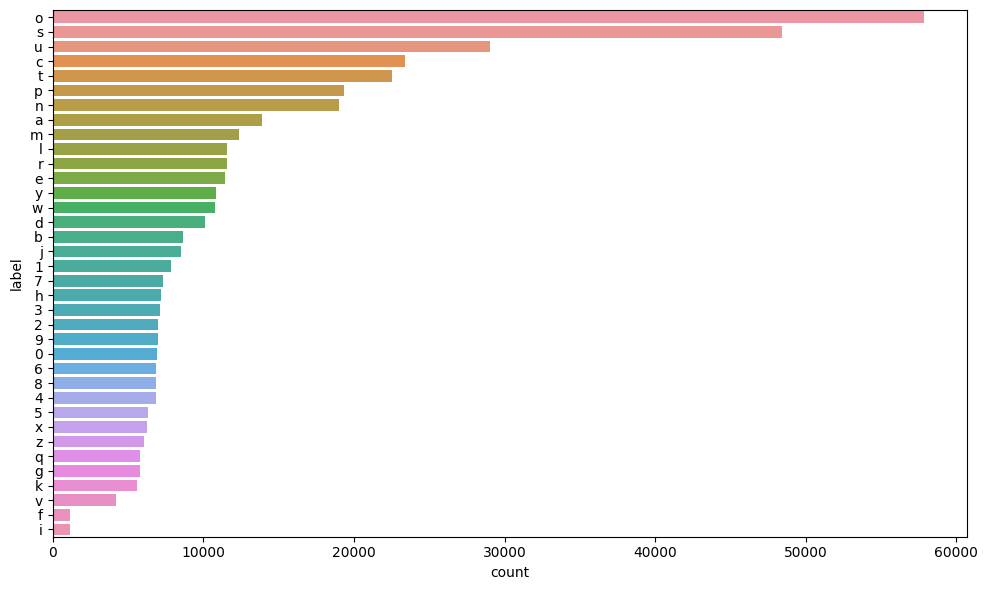

In [11]:
plt.rcParams['figure.figsize'] = (10,6)
label_col = df['label'].apply(lambda x: labels_name[x])
sns.countplot(y=label_col, order=label_col.value_counts().index)
plt.tight_layout();

In [12]:
train_img, val_img, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

In [13]:
print(f"Training images has shape: {train_img.shape} and dtype: {train_img.dtype}")
print(f"Training labels has shape: {train_labels.shape} and dtype: {train_labels.dtype}")
print(f"Validation images has shape: {val_img.shape} and dtype: {val_img.dtype}")
print(f"Validation labels has shape: {val_labels.shape} and dtype: {val_labels.dtype}")

Training images has shape: (353960, 28, 28) and dtype: float32
Training labels has shape: (353960,) and dtype: int64
Validation images has shape: (88491, 28, 28) and dtype: float32
Validation labels has shape: (88491,) and dtype: int64


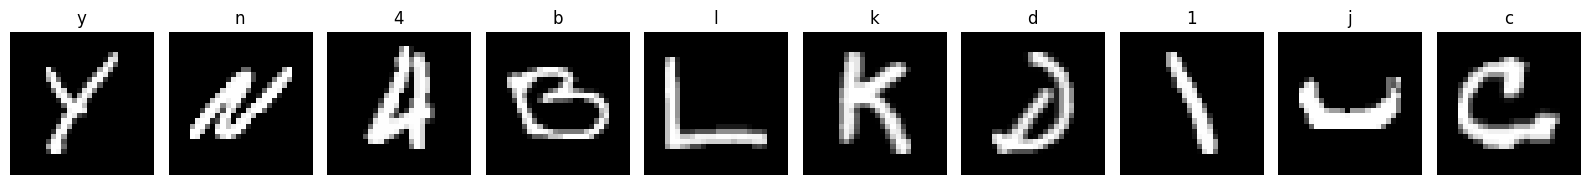

In [14]:

def plot_categories(training_images, training_labels):
  fig, axes = plt.subplots(1, 10, figsize=(16, 15))
  axes = axes.flatten()
  letters = labels_name

  for k in range(10):
    img = training_images[k]
    img = np.expand_dims(img, axis=-1)
    img = array_to_img(img)
    ax = axes[k]
    ax.imshow(img, cmap="Greys_r")
    ax.set_title(f"{letters[int(training_labels[k])]}")
    ax.set_axis_off()

  plt.tight_layout()
  plt.show()

plot_categories(val_img, val_labels)

## Creating the generators for the CNN

In [15]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(train_img, train_labels, val_img, val_labels):

  train_img = np.expand_dims(train_img, axis=-1)
  val_img = np.expand_dims(val_img, axis=-1)

  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')


  train_generator = train_datagen.flow(x=train_img,
                                       y=train_labels,
                                       batch_size=32) 

  val_datagen = ImageDataGenerator(rescale=1./255.0)

  val_generator = val_datagen.flow(x=val_img,
                                   y=val_labels,
                                   batch_size=32,
                                   shuffle=False) 

  return train_generator, val_generator

In [16]:
train_generator, val_generator = train_val_generators(train_img, train_labels, val_img, val_labels)

print(f"Images of training generator have shape: {train_generator.x.shape}")
print(f"Labels of training generator have shape: {train_generator.y.shape}")
print(f"Images of validation generator have shape: {val_generator.x.shape}")
print(f"Labels of validation generator have shape: {val_generator.y.shape}")

Images of training generator have shape: (353960, 28, 28, 1)
Labels of training generator have shape: (353960,)
Images of validation generator have shape: (88491, 28, 28, 1)
Labels of validation generator have shape: (88491,)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (5,5), strides=(2,2), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, (4,4), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(len(labels_name), activation='softmax')
])


model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 24, 24, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        25632     
                                                                 
 batch_normalization_2 (Batc  (None, 12, 12, 32)       1

In [ ]:
history = model.fit(train_generator,
                    epochs=35,
                    validation_data=val_generator)

Epoch 1/35
11062/11062 [==============================] - 272s 23ms/step - loss: 1.0826 - accuracy: 0.6835 - val_loss: 0.3315 - val_accuracy: 0.8997
Epoch 2/35
11062/11062 [==============================] - 258s 23ms/step - loss: 0.5979 - accuracy: 0.8197 - val_loss: 0.2625 - val_accuracy: 0.9186
Epoch 3/35
11062/11062 [==============================] - 257s 23ms/step - loss: 0.5127 - accuracy: 0.8441 - val_loss: 0.2560 - val_accuracy: 0.9187
Epoch 4/35
11062/11062 [==============================] - 255s 23ms/step - loss: 0.4734 - accuracy: 0.8567 - val_loss: 0.2241 - val_accuracy: 0.9302
Epoch 5/35
11062/11062 [==============================] - 252s 23ms/step - loss: 0.4434 - accuracy: 0.8650 - val_loss: 0.2334 - val_accuracy: 0.9265
Epoch 6/35
11062/11062 [==============================] - 256s 23ms/step - loss: 0.4204 - accuracy: 0.8715 - val_loss: 0.2325 - val_accuracy: 0.9270
Epoch 7/35
11062/11062 [==============================] - 250s 23ms/step - loss: 0.4061 - accuracy: 0.8757

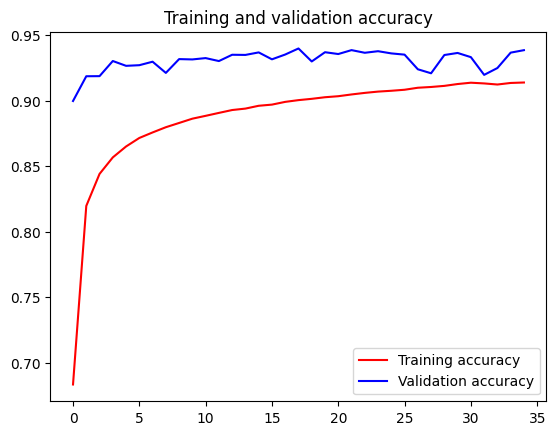

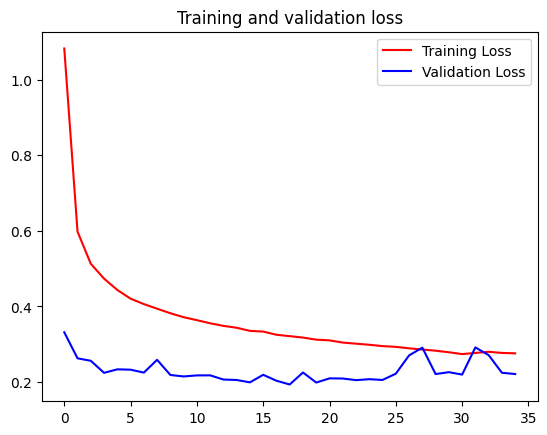

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('/content/drive/MyDrive/OCR classify handwriting/saved_model', save_format="h5")

In [17]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/OCR classify handwriting/saved_model')

In [18]:
import seaborn as sns
import pandas as pd

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accuracy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

def plot_cm(cm):
  plt.figure(figsize=(20,15))
  df_cm = pd.DataFrame(cm, index=labels_name, columns=labels_name)
  ax = sns.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

In [19]:
pred_probs = model.predict(val_generator, verbose=1)
pred_probs

2766/2766 [==============================] - 26s 5ms/step


array([[9.85525439e-10, 9.18728074e-06, 3.09501047e-06, ...,
        1.57493676e-04, 9.98593509e-01, 7.97270218e-07],
       [6.47165266e-10, 5.74083060e-07, 1.14367666e-07, ...,
        3.20422487e-07, 9.88392549e-06, 1.47386754e-06],
       [7.83595970e-05, 3.60076723e-04, 6.98521035e-05, ...,
        9.64440987e-05, 1.22268393e-04, 3.03997331e-05],
       ...,
       [1.50935492e-07, 1.09608345e-06, 7.92609717e-06, ...,
        5.47536001e-06, 4.35000211e-01, 1.84062185e-06],
       [3.10159066e-06, 4.92575047e-08, 2.37597874e-03, ...,
        1.23272713e-07, 1.80390782e-06, 1.22212281e-03],
       [2.93203300e-07, 7.67024687e-07, 4.67220161e-06, ...,
        7.85482644e-06, 4.23673919e-06, 4.70107443e-06]], dtype=float32)

In [20]:
preds = pred_probs.argmax(axis=1)
preds[:10]

array([34, 23,  4, 11, 21, 20, 13,  1, 12, 12])

In [21]:
val_true_labels = val_generator.y
val_true_labels[:10]

array([34, 23,  4, 11, 21, 20, 13,  1, 19, 12])

In [22]:
calculate_result(y_true=val_true_labels,
                 y_pred=preds)

{'accuracy': 0.938490919980563,
 'precision': 0.941471845454302,
 'recall': 0.938490919980563,
 'f1-score': 0.9306328991686964}

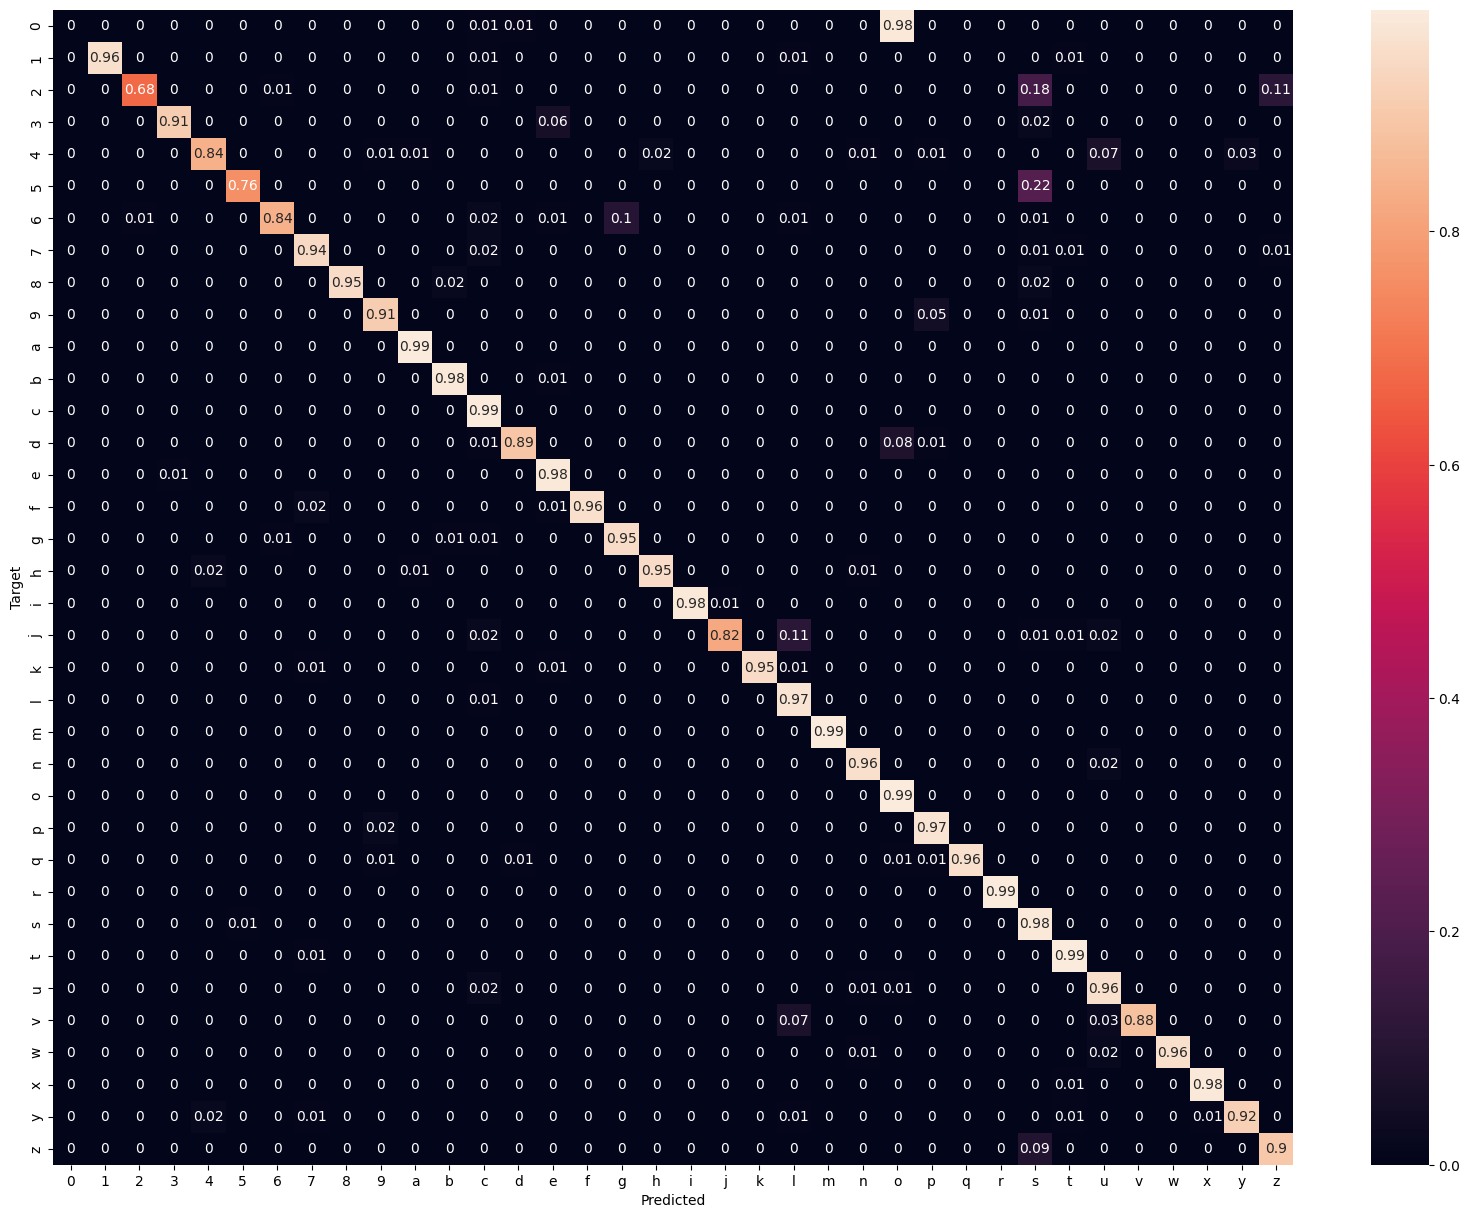

In [23]:
cm = np.around(confusion_matrix(val_labels, preds, normalize='true'), decimals=2)
plot_cm(cm)

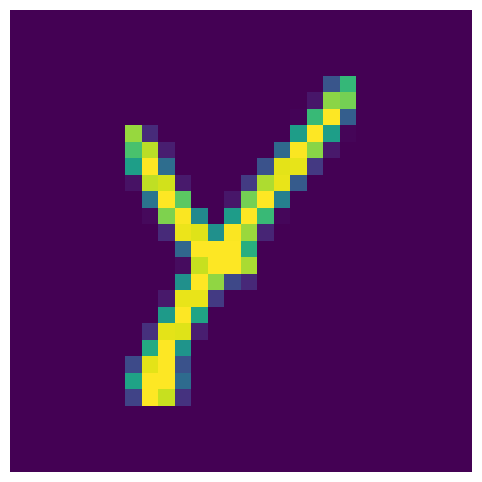

1/1 [==============================] - 1s 620ms/step
True label: y
Predicted label: y


In [24]:
x, y = next(iter(val_generator))
image = x[0, :, :, :]
true_index = y[0]
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 28, 28, 1) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + labels_name[true_index])
print("Predicted label: " + labels_name[predicted_index])